# Import Libraries

In [43]:
import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMG_SIZE=96
BATCH_SIZE=32

# Import Dataset

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abylainur","key":"cc7242f15140aff05ed625a19804b133"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jehanbhathena/weather-dataset
!unzip weather-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset

In [5]:
path = '/content/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [6]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='path').astype(str)
labels = pd.Series(labels, name='label')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,path,label
0,/content/dataset/rime/5160.jpg,rime
1,/content/dataset/fogsmog/4420.jpg,fogsmog
2,/content/dataset/hail/0511.jpg,hail
3,/content/dataset/hail/0382.jpg,hail
4,/content/dataset/rime/5227.jpg,rime


In [ ]:
labels

0       lightning
1       lightning
2       lightning
3       lightning
4       lightning
          ...    
6857         hail
6858         hail
6859         hail
6860         hail
6861         hail
Name: label, Length: 6862, dtype: object

In [7]:
train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=2)

## **Displaying images**

sandstorm


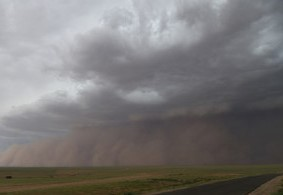


lightning


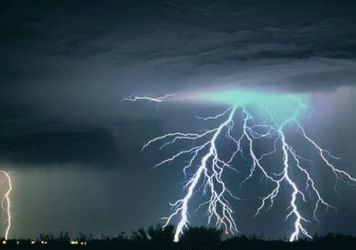


hail


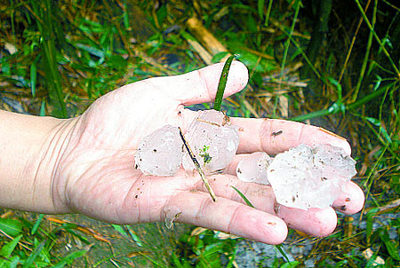

In [10]:
for n in range(3):
  i = random.randint(0, 100)
  image_path = train_ds.loc[i]['path']
  print(train_ds.loc[i]['label'])
  display.display(display.Image(image_path))
  print()

## Data Argumentation

In [35]:
from keras.preprocessing.image import ImageDataGenerator

def generate_data(train_ds, test_ds):
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_ds,
        x_col='path',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',)

  validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_ds,
        x_col='path',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)
  return train_generator, validation_generator

In [36]:
train_generator, validation_generator = generate_data(train_ds, test_ds)

Found 5489 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


In [13]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 96, 96, 3)
labels batch shape: (32, 11)


In [14]:
labels = train_generator.class_indices
labels = dict((value, key) for key, value in labels.items())
labels

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## Visualizing data

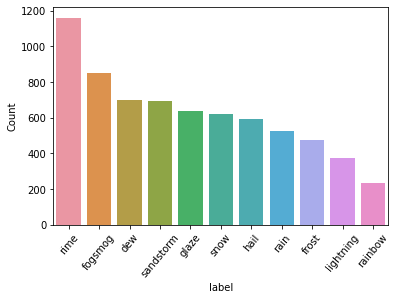

In [29]:
counts = data.label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('label')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [45]:
def plot(history, validation_generator, train_generator,model):
  # Val_accuracy graphic and val_loss graphic
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
  # prints prediction for each class
  pred = model.predict(validation_generator )
  pred = np.argmax(pred,axis=1)
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]

  cm=confusion_matrix(test_ds.label,pred)
  clr = classification_report(test_ds.label, pred)
  print(clr)

## Creating a CNN model

In [40]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=8)

Epoch 1/8
172/172 [==============================] - 54s 298ms/step - loss: 2.1154 - accuracy: 0.2674 - val_loss: 1.7701 - val_accuracy: 0.3496
Epoch 2/8
172/172 [==============================] - 51s 298ms/step - loss: 1.7303 - accuracy: 0.4137 - val_loss: 1.4395 - val_accuracy: 0.4931
Epoch 3/8
172/172 [==============================] - 57s 331ms/step - loss: 1.5645 - accuracy: 0.4717 - val_loss: 1.2837 - val_accuracy: 0.5776
Epoch 4/8
172/172 [==============================] - 57s 331ms/step - loss: 1.4438 - accuracy: 0.5041 - val_loss: 1.1903 - val_accuracy: 0.5936
Epoch 5/8
172/172 [==============================] - 52s 303ms/step - loss: 1.3933 - accuracy: 0.5210 - val_loss: 1.2688 - val_accuracy: 0.5601
Epoch 6/8
172/172 [==============================] - 52s 301ms/step - loss: 1.3616 - accuracy: 0.5247 - val_loss: 1.2315 - val_accuracy: 0.5812
Epoch 7/8
172/172 [==============================] - 60s 348ms/step - loss: 1.3353 - accuracy: 0.5340 - val_loss: 1.1958 - val_accuracy:

43/43 [==============================] - 6s 150ms/step
              precision    recall  f1-score   support

         dew       0.77      0.84      0.80       128
     fogsmog       0.85      0.74      0.79       155
       frost       0.35      0.66      0.46        88
       glaze       0.31      0.40      0.35       138
        hail       0.47      0.46      0.47       117
   lightning       0.78      0.83      0.80        83
        rain       0.54      0.24      0.34       115
     rainbow       0.70      0.27      0.39        51
        rime       0.71      0.78      0.74       232
   sandstorm       0.81      0.87      0.84       126
        snow       0.66      0.45      0.54       140

    accuracy                           0.62      1373
   macro avg       0.63      0.60      0.59      1373
weighted avg       0.64      0.62      0.62      1373



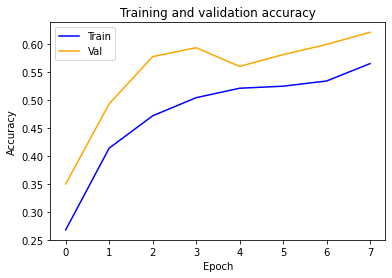

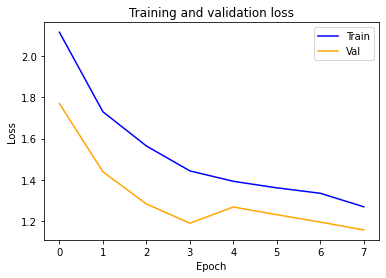

In [46]:
plot(history, validation_generator, train_generator, model)

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp my_model.h5 '/content/gdrive/MyDrive/images/'
!ls -lt '/content/gdrive/MyDrive/images/' 

## Using transfer learning

### Xception

In [48]:
base_model = tf.keras.applications.Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")
base_model.trainable = False 

prediction_layer = tf.keras.layers.Dense(11, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64),
  prediction_layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
172/172 [==============================] - 67s 362ms/step - loss: 2.7469 - accuracy: 0.5118 - val_loss: 1.1635 - val_accuracy: 0.6504
Epoch 2/5
172/172 [==============================] - 51s 297ms/step - loss: 1.4528 - accuracy: 0.6085 - val_loss: 1.0811 - val_accuracy: 0.6431
Epoch 3/5
172/172 [==============================] - 51s 298ms/step - loss: 1.2522 - accuracy: 0.6424 - val_loss: 1.0836 - val_accuracy: 0.6504
Epoch 4/5
172/172 [==============================] - 55s 320ms/step - loss: 1.1799 - accuracy: 0.6447 - val_loss: 0.9786 - val_accuracy: 0.6788
Epoch 5/5
172/172 [==============================] - 51s 296ms/step - loss: 1.1173 - accuracy: 0.6633 - val_loss: 1.0175 - val_accuracy: 0.6730


43/43 [==============================] - 9s 183ms/step
              precision    recall  f1-score   support

         dew       0.85      0.74      0.79       128
     fogsmog       0.52      0.81      0.63       155
       frost       0.50      0.44      0.47        88
       glaze       0.60      0.41      0.49       138
        hail       0.72      0.73      0.72       117
   lightning       0.87      0.78      0.82        83
        rain       0.63      0.83      0.72       115
     rainbow       0.82      0.73      0.77        51
        rime       0.73      0.71      0.72       232
   sandstorm       0.70      0.73      0.71       126
        snow       0.69      0.49      0.58       140

    accuracy                           0.67      1373
   macro avg       0.69      0.67      0.67      1373
weighted avg       0.68      0.67      0.67      1373



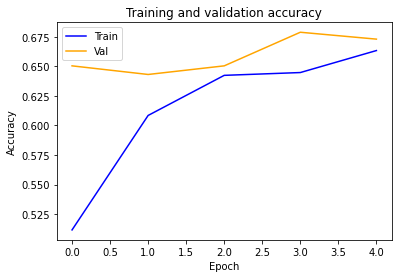

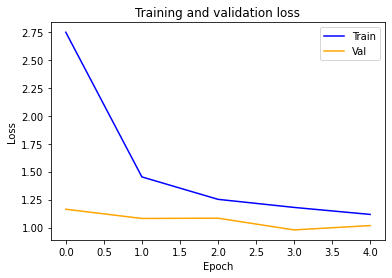

In [49]:
plot(history, validation_generator, train_generator, model)

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### MobileNetV2

In [51]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")
base_model.trainable = False 

prediction_layer = tf.keras.layers.Dense(11, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64),
  prediction_layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
172/172 [==============================] - 68s 372ms/step - loss: 6.8555 - accuracy: 0.5968 - val_loss: 3.2306 - val_accuracy: 0.7072
Epoch 2/5
172/172 [==============================] - 51s 298ms/step - loss: 3.0656 - accuracy: 0.6774 - val_loss: 1.8480 - val_accuracy: 0.7400
Epoch 3/5
172/172 [==============================] - 52s 305ms/step - loss: 1.9027 - accuracy: 0.6972 - val_loss: 1.3350 - val_accuracy: 0.7764
Epoch 4/5
172/172 [==============================] - 52s 305ms/step - loss: 1.5508 - accuracy: 0.7060 - val_loss: 1.2713 - val_accuracy: 0.7312
Epoch 5/5
172/172 [==============================] - 56s 324ms/step - loss: 1.3903 - accuracy: 0.7078 - val_loss: 1.2195 - val_accuracy: 0.7422


43/43 [==============================] - 8s 179ms/step
              precision    recall  f1-score   support

         dew       0.84      0.84      0.84       128
     fogsmog       0.74      0.90      0.81       155
       frost       0.47      0.78      0.58        88
       glaze       0.72      0.30      0.42       138
        hail       0.99      0.65      0.78       117
   lightning       0.94      0.93      0.93        83
        rain       0.66      0.86      0.75       115
     rainbow       0.95      0.82      0.88        51
        rime       0.71      0.92      0.80       232
   sandstorm       0.84      0.63      0.72       126
        snow       0.74      0.54      0.62       140

    accuracy                           0.74      1373
   macro avg       0.78      0.74      0.74      1373
weighted avg       0.77      0.74      0.73      1373



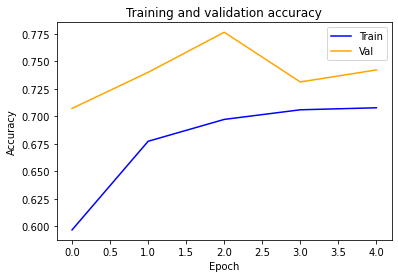

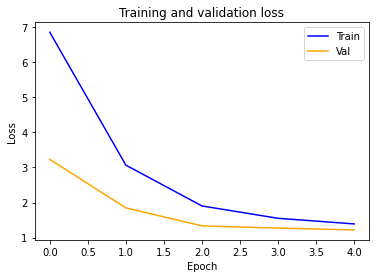

In [53]:
plot(history, validation_generator, train_generator, model)

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp my_model.h5 '/content/gdrive/MyDrive/images/'
!ls -lt '/content/gdrive/MyDrive/images/' 

total 43917
-rw------- 1 root root 44958648 Feb 20 18:30 my_model.h5
drwx------ 2 root root     4096 Feb  5 15:15 book
drwx------ 2 root root     4096 Feb  5 15:15 rubiks_cube
drwx------ 2 root root     4096 Feb  5 15:13 toy_duck


### InceptionV3

In [55]:
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")
base_model.trainable = False 

prediction_layer = tf.keras.layers.Dense(11, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128),
  prediction_layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
172/172 [==============================] - 57s 302ms/step - loss: 2.0669 - accuracy: 0.4383 - val_loss: 1.2578 - val_accuracy: 0.5717
Epoch 2/5
172/172 [==============================] - 50s 291ms/step - loss: 1.4868 - accuracy: 0.5320 - val_loss: 1.1902 - val_accuracy: 0.5994
Epoch 3/5
172/172 [==============================] - 50s 291ms/step - loss: 1.3744 - accuracy: 0.5562 - val_loss: 1.1513 - val_accuracy: 0.6184
Epoch 4/5
172/172 [==============================] - 50s 292ms/step - loss: 1.3353 - accuracy: 0.5700 - val_loss: 1.1560 - val_accuracy: 0.6082
Epoch 5/5
172/172 [==============================] - 49s 287ms/step - loss: 1.3436 - accuracy: 0.5680 - val_loss: 1.2088 - val_accuracy: 0.6038


43/43 [==============================] - 8s 166ms/step
              precision    recall  f1-score   support

         dew       0.65      0.64      0.64       128
     fogsmog       0.53      0.77      0.63       155
       frost       0.83      0.06      0.11        88
       glaze       0.52      0.43      0.47       138
        hail       0.64      0.74      0.68       117
   lightning       0.58      0.93      0.72        83
        rain       0.71      0.55      0.62       115
     rainbow       0.97      0.61      0.75        51
        rime       0.64      0.78      0.70       232
   sandstorm       0.53      0.63      0.58       126
        snow       0.58      0.33      0.42       140

    accuracy                           0.60      1373
   macro avg       0.65      0.59      0.57      1373
weighted avg       0.63      0.60      0.58      1373



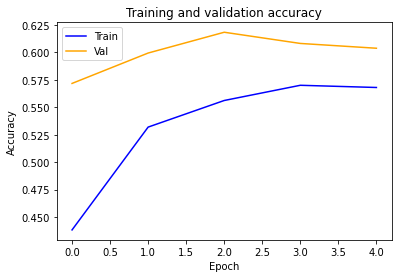

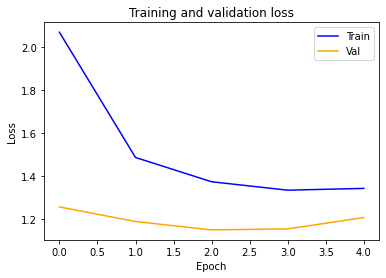

In [56]:
plot(history, validation_generator, train_generator, model)

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp my_model.h5 '/content/gdrive/MyDrive/images/'
!ls -lt '/content/gdrive/MyDrive/images/' 

total 88982
-rw------- 1 root root 91105056 Feb 20 19:05 my_model.h5
drwx------ 2 root root     4096 Feb  5 15:15 book
drwx------ 2 root root     4096 Feb  5 15:15 rubiks_cube
drwx------ 2 root root     4096 Feb  5 15:13 toy_duck


### DenseNet121

In [57]:
base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")
base_model.trainable = False 

prediction_layer = tf.keras.layers.Dense(11, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128),
  prediction_layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/5
172/172 [==============================] - 63s 323ms/step - loss: 4.1058 - accuracy: 0.5580 - val_loss: 1.5783 - val_accuracy: 0.6715
Epoch 2/5
172/172 [==============================] - 50s 291ms/step - loss: 1.6128 - accuracy: 0.6580 - val_loss: 0.8993 - val_accuracy: 0.7240
Epoch 3/5
172/172 [==============================] - 50s 289ms/step - loss: 1.2038 - accuracy: 0.6861 - val_loss: 1.0235 - val_accuracy: 0.7028
Epoch 4/5
172/172 [==============================] - 51s 295ms/step - loss: 1.2251 - accuracy: 0.6819 - val_loss: 0.9134 - val_accuracy: 0.7240
Epoch 5/5
172/172 [==============================] - 53s 308ms/step - loss: 1.3489 - accuracy: 0.6808 - val_loss: 1.1604 - val_accuracy: 0.6803


43/43 [==============================] - 9s 174ms/step
              precision    recall  f1-score   support

         dew       0.89      0.80      0.84       128
     fogsmog       0.97      0.21      0.35       155
       frost       0.64      0.61      0.62        88
       glaze       0.67      0.46      0.55       138
        hail       0.81      0.84      0.82       117
   lightning       0.90      0.89      0.90        83
        rain       0.60      0.87      0.71       115
     rainbow       0.92      0.92      0.92        51
        rime       0.78      0.80      0.79       232
   sandstorm       0.41      0.99      0.58       126
        snow       0.63      0.37      0.47       140

    accuracy                           0.68      1373
   macro avg       0.75      0.71      0.69      1373
weighted avg       0.74      0.68      0.67      1373



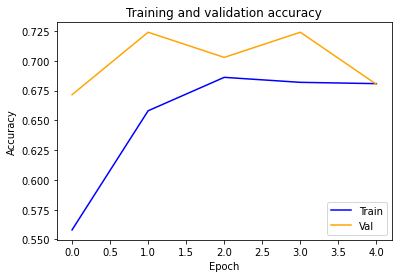

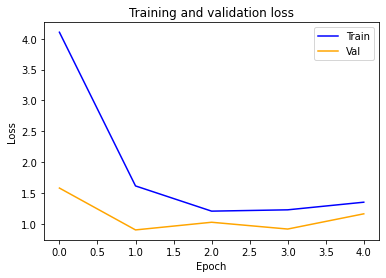

In [58]:
plot(history, validation_generator, train_generator, model)

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
!cp my_model.h5 '/content/gdrive/MyDrive/images/'
!ls -lt '/content/gdrive/MyDrive/images/' 

total 42251
-rw------- 1 root root 43251848 Feb 20 20:08 my_model.h5
drwx------ 2 root root     4096 Feb  5 15:15 book
drwx------ 2 root root     4096 Feb  5 15:15 rubiks_cube
drwx------ 2 root root     4096 Feb  5 15:13 toy_duck
